In [1]:
!pip install sklearn
!pip install optuna
!pip install xgboost
!pip install numpy

You should consider upgrading via the '/Users/max/Desktop/Code/nlp_venv/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/max/Desktop/Code/nlp_venv/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/max/Desktop/Code/nlp_venv/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/max/Desktop/Code/nlp_venv/bin/python3 -m pip install --upgrade pip' command.


In [2]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import numpy as np 
import optuna
import os 
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [3]:
dir = "Kaggle_Datasets"
os.listdir(dir)
cost_pred_csv = dir + "/media prediction and its cost.csv"

In [4]:
cost_df = pd.read_csv(cost_pred_csv)

#Using Sales country as stratify 
train_df, test_df = train_test_split(cost_df, train_size= 0.8, shuffle= True, stratify= cost_df['sales_country'])

In [5]:
train_df

,food_category,food_department,food_family,store_sales(in millions),store_cost(in millions),unit_sales(in millions),promotion_name,sales_country,marital_status,gender,...,grocery_sqft,frozen_sqft,meat_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,media_type,cost
20231,Specialty,Produce,Food,2.58,1.0320,2.0,Price Cutters,USA,M,M,...,15337.0,5011.0,3340.0,1.0,1.0,1.0,1.0,1.0,Product Attachment,129.20
29369,Meat,Deli,Food,9.08,2.8148,4.0,Best Savings,Mexico,M,M,...,26354.0,5062.0,3375.0,0.0,0.0,1.0,1.0,0.0,Cash Register Handout,110.17
53859,Vegetables,Frozen Foods,Food,2.72,0.9248,1.0,Sales Galore,USA,S,F,...,22271.0,3561.0,2374.0,1.0,0.0,0.0,0.0,0.0,"Daily Paper, Radio",109.03
5744,Vegetables,Produce,Food,2.43,0.8262,3.0,Bye Bye Baby,Canada,M,F,...,16418.0,4016.0,2678.0,1.0,1.0,1.0,1.0,1.0,Sunday Paper,138.18
30917,Frozen Desserts,Frozen Foods,Food,6.42,2.1186,2.0,Weekend Markdown,Mexico,M,F,...,16844.0,4149.0,2766.0,1.0,0.0,1.0,1.0,1.0,TV,89.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3464,Vegetables,Produce,Food,4.46,2.0516,2.0,Savings Galore,USA,S,M,...,22063.0,4923.0,3282.0,0.0,0.0,0.0,0.0,0.0,"Sunday Paper, Radio",136.57
10467,Dairy,Dairy,Food,14.44,7.2200,4.0,Super Duper Savers,USA,S,F,...,22123.0,7041.0,4694.0,1.0,0.0,1.0,1.0,1.0,Sunday Paper,69.65
2650,Vegetables,Produce,Food,4.29,2.0592,3.0,Three for One,USA,M,M,...,22123.0,7041.0,4694.0,1.0,0.0,1.0,1.0,1.0,Product Attachment,122.47
59522,Bathroom Products,Household,Non-Consumable,2.78,1.0286,2.0,Sales Days,USA,M,F,...,22063.0,4923.0,3282.0,0.0,0.0,0.0,0.0,0.0,Bulk Mail,116.74


In [6]:
len(train_df.columns)

40

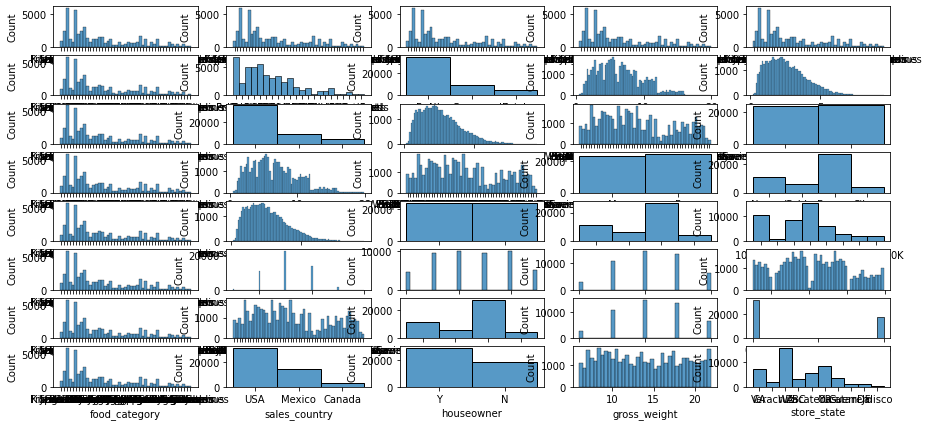

In [7]:
n_rows = 8
n_cols = 5

fig, ax = plt.subplots(n_rows,n_cols, figsize = (15,7))
for i in range(n_rows):
    for j in range(n_cols):
        sns.histplot(train_df.iloc[:,i*j], ax = ax[i, j])

In [8]:
train_df['num_children_at_home'].dtype
train_df['cost'].astype(float)

20231    129.20
29369    110.17
53859    109.03
5744     138.18
30917     89.90
          ...  
3464     136.57
10467     69.65
2650     122.47
59522    116.74
29526    118.25
Name: cost, Length: 48342, dtype: float64

In [9]:
#Checking for outliers 

numeric = [a for a in train_df.columns if train_df[a].dtype == 'float64']
categoric = [a for a in train_df.columns if a not in numeric]

aesthetic = numeric[-6:]
numeric = numeric[:-6] #Excluding one-hot encoded value within dataset
numeric

['store_sales(in millions)',
 'store_cost(in millions)',
 'unit_sales(in millions)',
 'total_children',
 'avg_cars_at home(approx)',
 'num_children_at_home',
 'avg_cars_at home(approx).1',
 'SRP',
 'gross_weight',
 'net_weight',
 'recyclable_package',
 'low_fat',
 'units_per_case',
 'store_sqft',
 'grocery_sqft',
 'frozen_sqft',
 'meat_sqft']

In [10]:
categoric

['food_category',
 'food_department',
 'food_family',
 'promotion_name',
 'sales_country',
 'marital_status',
 'gender',
 'education',
 'member_card',
 'occupation',
 'houseowner',
 'avg. yearly_income',
 'brand_name',
 'store_type',
 'store_city',
 'store_state',
 'media_type']

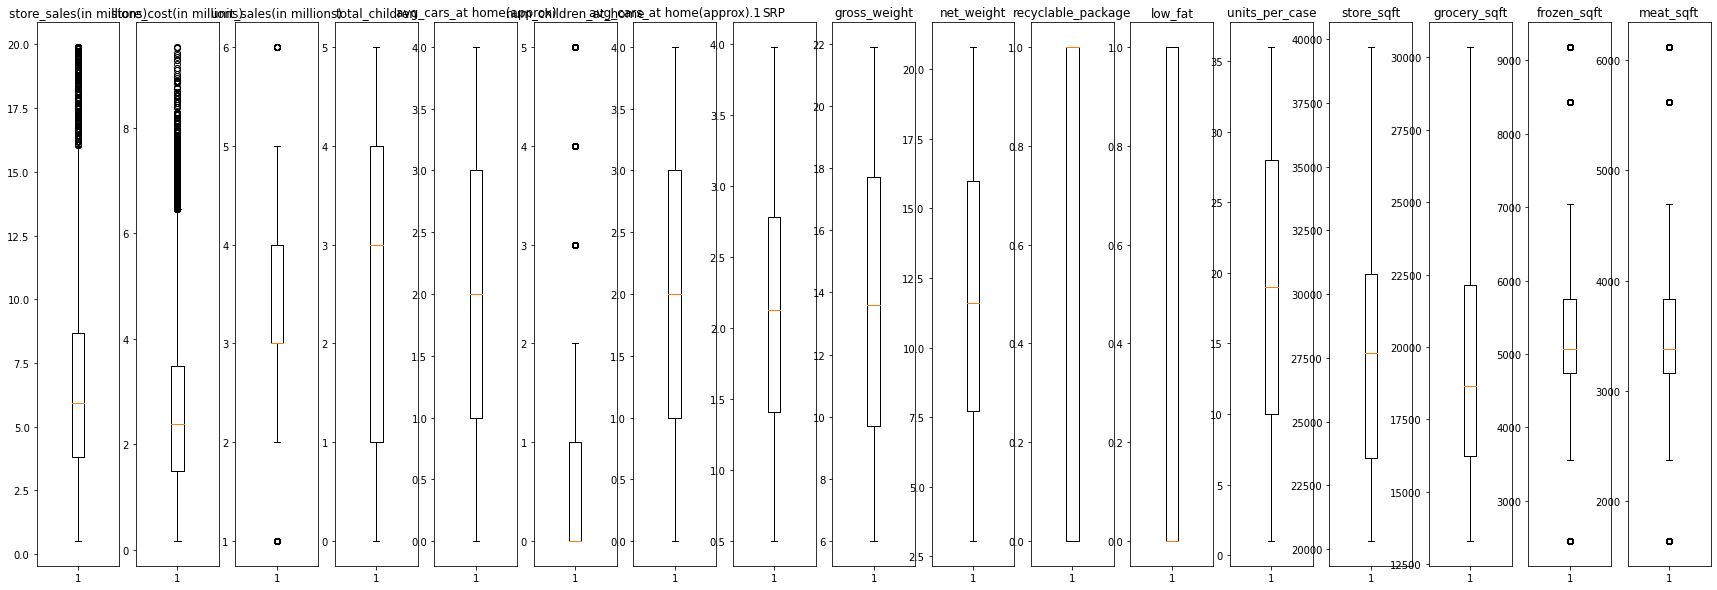

In [11]:
fig, ax = plt.subplots(1,len(numeric), figsize = (30,10))

for i,j in enumerate(numeric):
    ax[i].boxplot(train_df[j])
    ax[i].set_title(j)

{'whiskers': [<matplotlib.lines.Line2D at 0x288099b20>,
 'caps': [<matplotlib.lines.Line2D at 0x288099fa0>,
 'boxes': [<matplotlib.lines.Line2D at 0x288099850>],
 'medians': [<matplotlib.lines.Line2D at 0x2880a7580>],
 'fliers': [<matplotlib.lines.Line2D at 0x2880a7850>],
 'means': []}

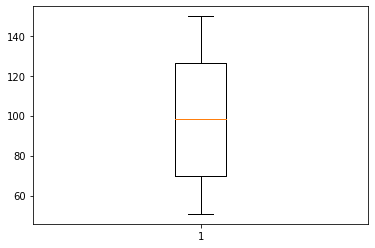

In [12]:
#Target variable
y = train_df['cost']
plt.boxplot(y)

<AxesSubplot:xlabel='sales_country', ylabel='Count'>

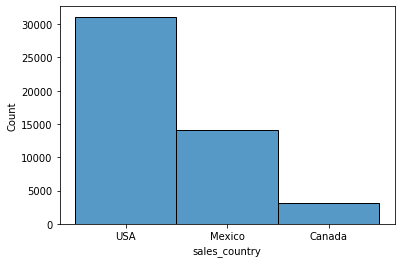

In [13]:
sns.histplot(train_df['sales_country'])

<AxesSubplot:>

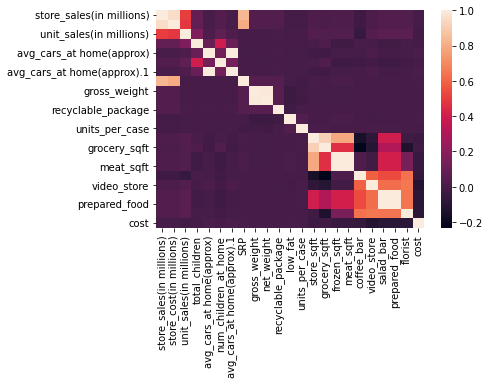

In [14]:
sns.heatmap(train_df.corr())

Assessing if aesthetics affect cost of acquiring a consumer

In [15]:
train_df.loc[:,aesthetic]

,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
20231,1.0,1.0,1.0,1.0,1.0,129.20
29369,0.0,0.0,1.0,1.0,0.0,110.17
53859,1.0,0.0,0.0,0.0,0.0,109.03
5744,1.0,1.0,1.0,1.0,1.0,138.18
30917,1.0,0.0,1.0,1.0,1.0,89.90
...,...,...,...,...,...,...
3464,0.0,0.0,0.0,0.0,0.0,136.57
10467,1.0,0.0,1.0,1.0,1.0,69.65
2650,1.0,0.0,1.0,1.0,1.0,122.47
59522,0.0,0.0,0.0,0.0,0.0,116.74


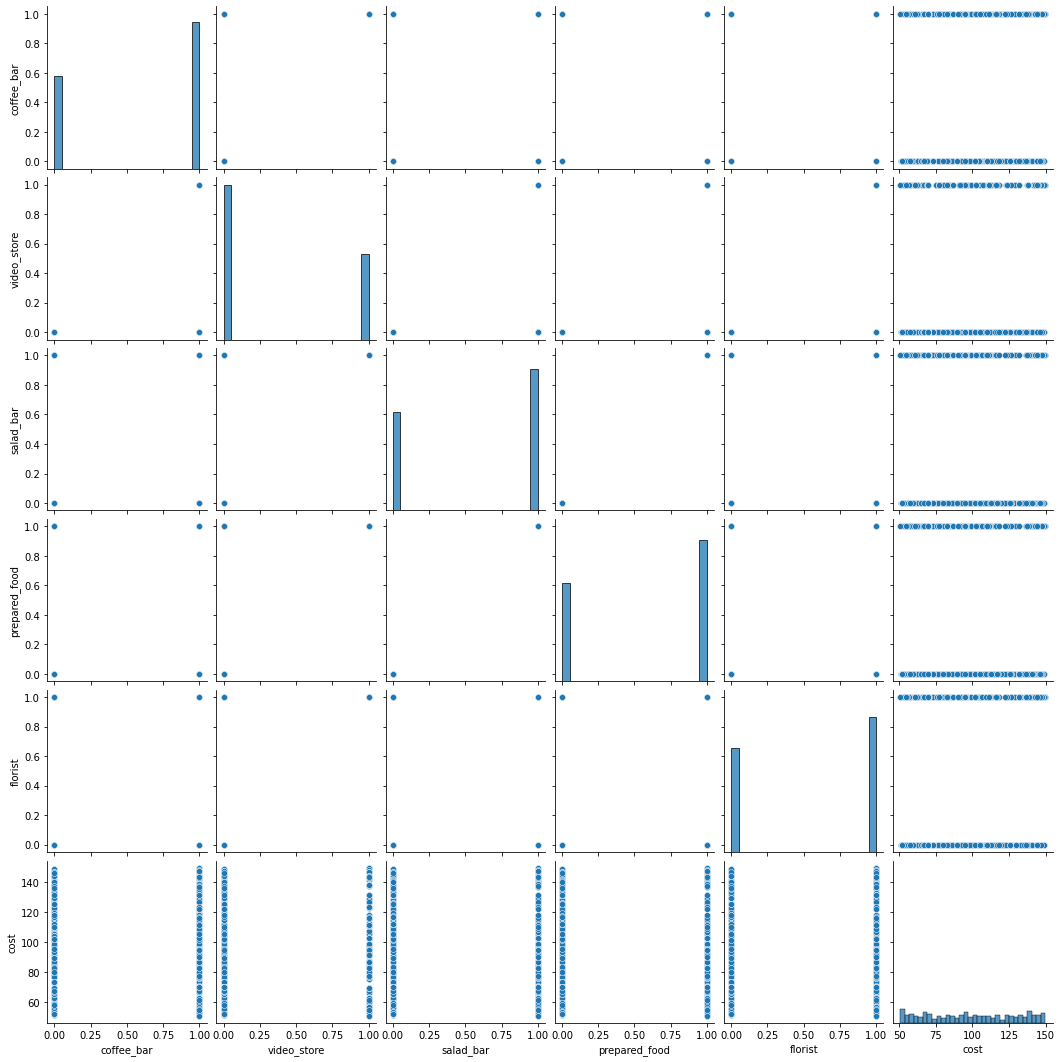

In [16]:
sns.pairplot(train_df.loc[:,aesthetic])

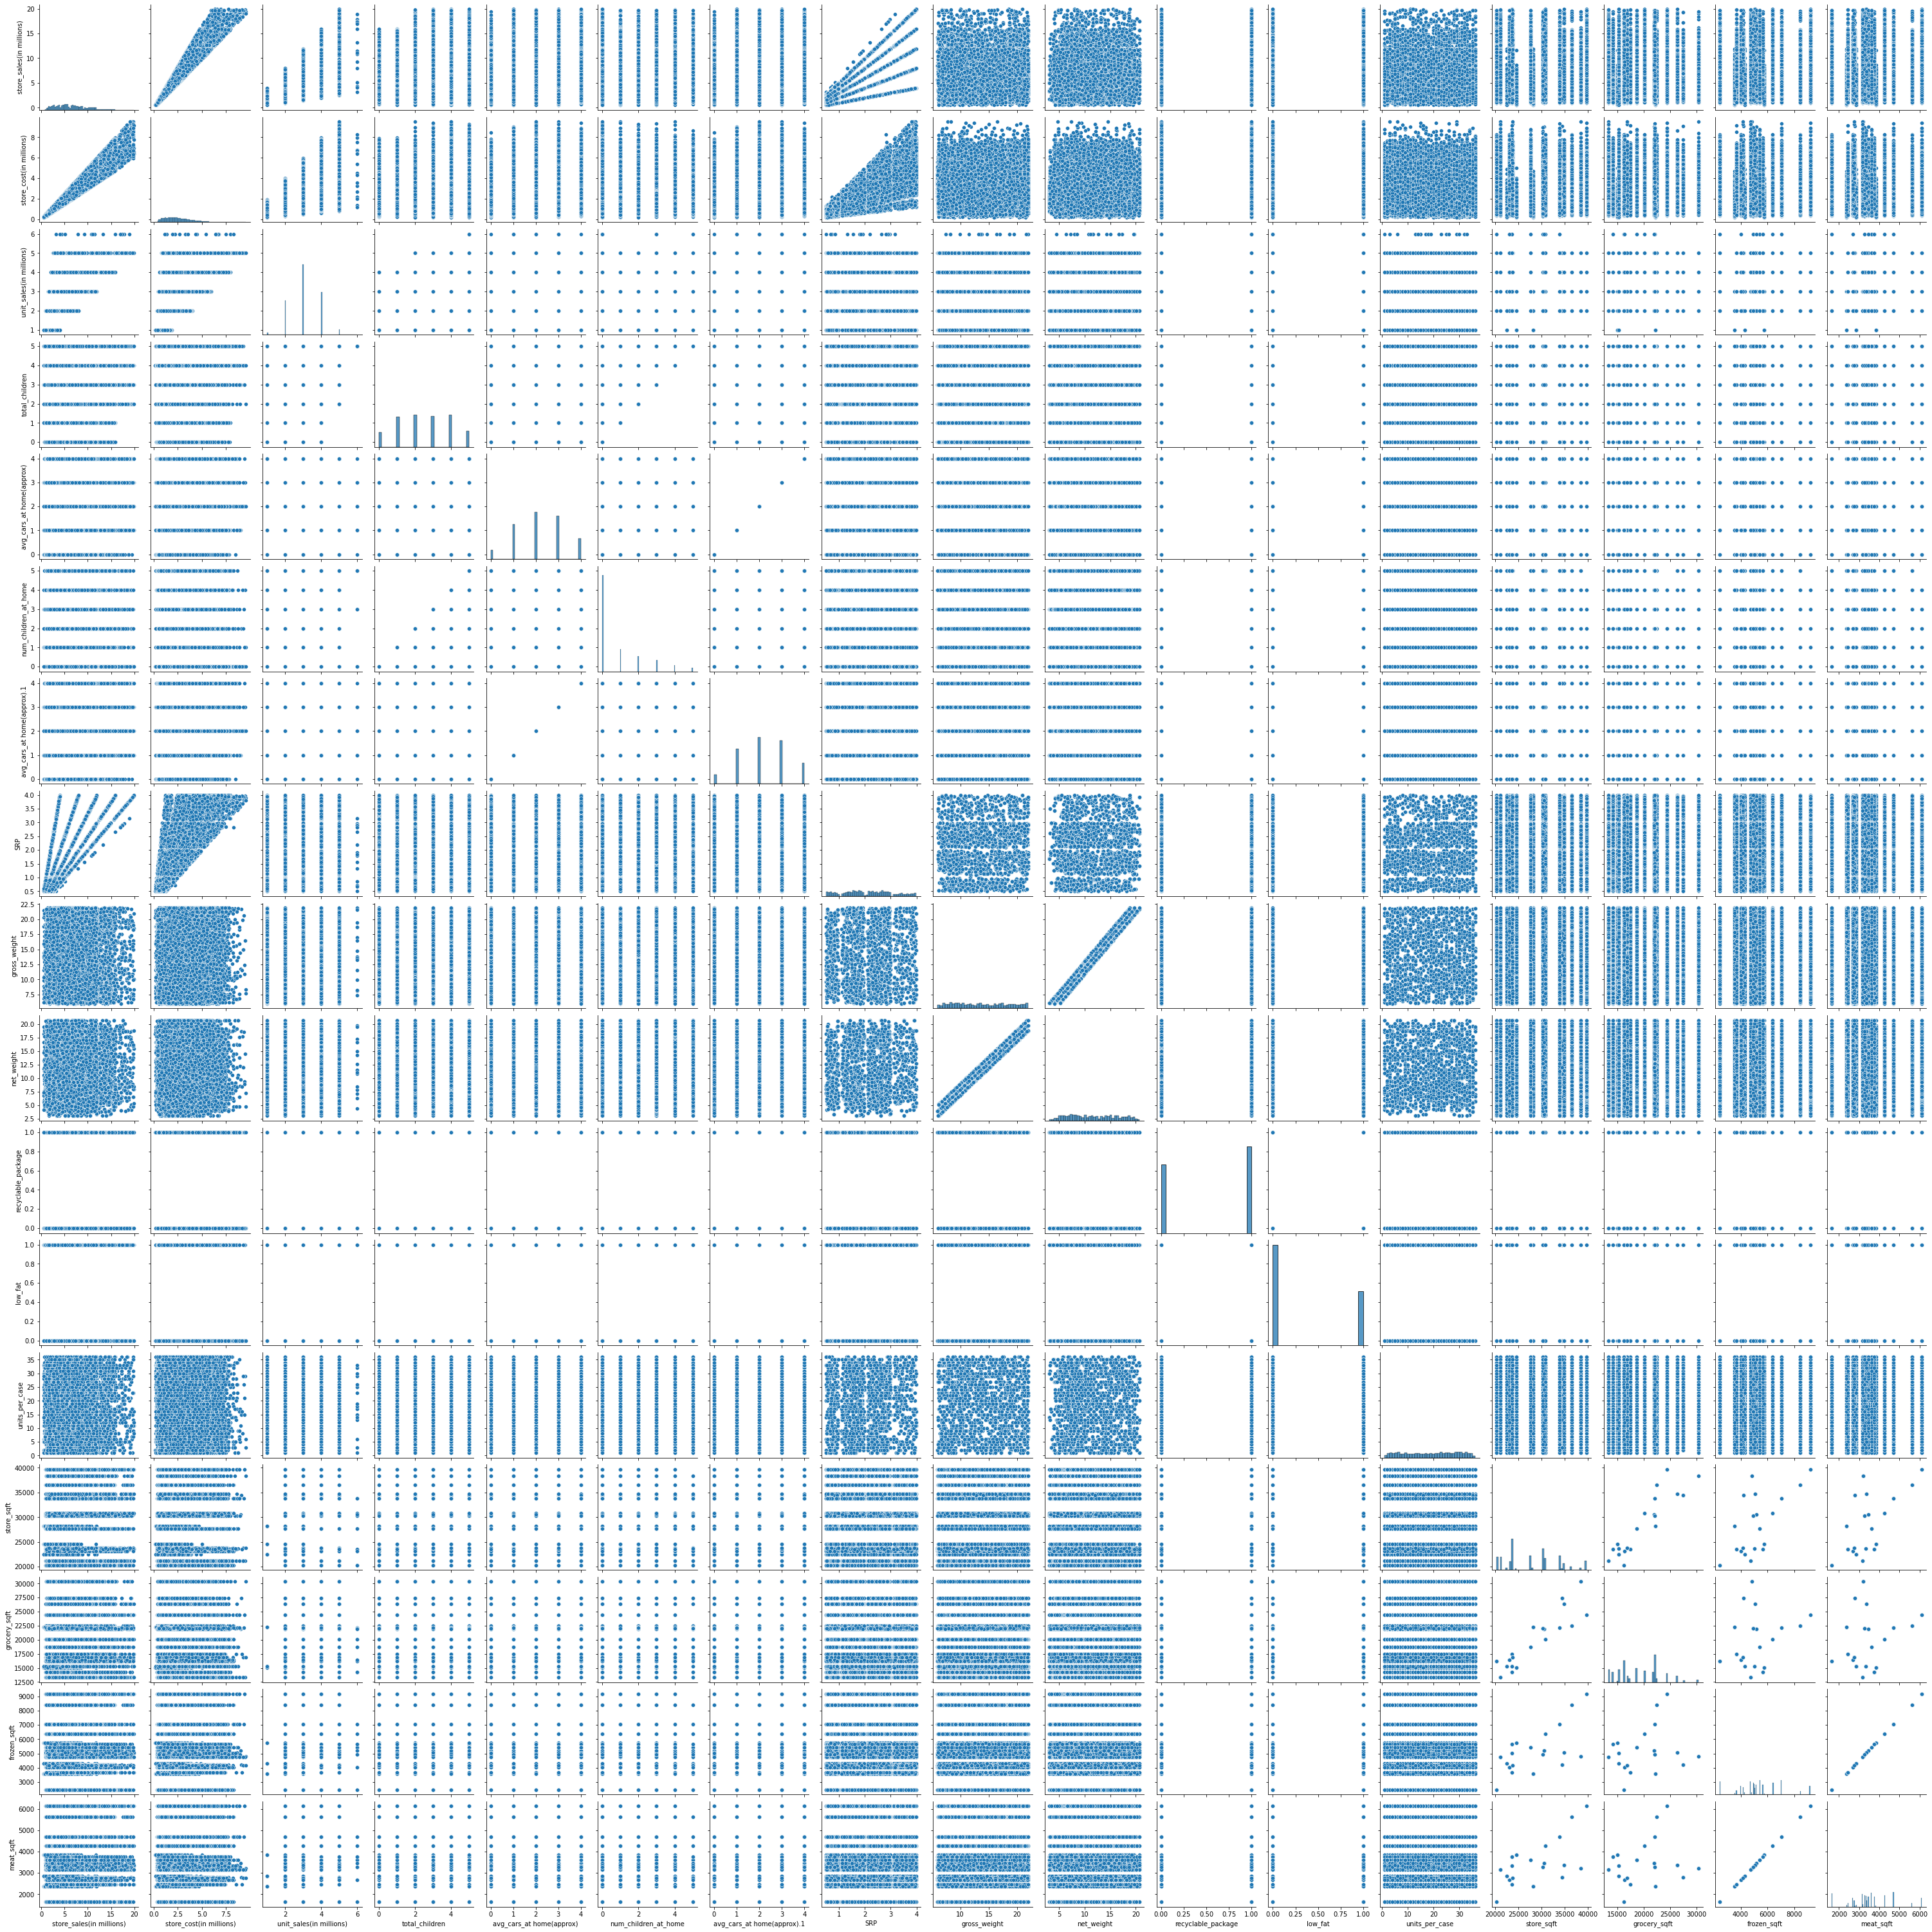

In [17]:
sns.pairplot(train_df.loc[:,numeric])

In [18]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import OneHotEncoder

#Using OneHotEncoding

f_train = pd.get_dummies(train_df.loc[:,categoric])
f_train = np.array(f_train)

f_test = pd.get_dummies(test_df.loc[:,categoric])
f_test = np.array(f_test)

#Using label Encoder
train_2 = train_df.copy()
test_2 = test_df.copy()

for a in list(train_df.loc[:,categoric]):
    le = LabelEncoder()
    train_2[a] = le.fit_transform(train_2[a])
    test_2[a] = le.fit_transform(test_2[a])


d = DictVectorizer() #Alternative to one hot encoding
d = d.fit_transform(dict(train_df.loc[:,categoric]))
d[0,:]

<1x308 sparse matrix of type '<class 'numpy.float64'>'
	with 821814 stored elements in Compressed Sparse Row format>

In [19]:
train_2

,food_category,food_department,food_family,store_sales(in millions),store_cost(in millions),unit_sales(in millions),promotion_name,sales_country,marital_status,gender,...,grocery_sqft,frozen_sqft,meat_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,media_type,cost
20231,42,17,1,2.58,1.0320,2.0,24,2,0,1,...,15337.0,5011.0,3340.0,1.0,1.0,1.0,1.0,1.0,6,129.20
29369,31,10,1,9.08,2.8148,4.0,1,1,0,1,...,26354.0,5062.0,3375.0,0.0,0.0,1.0,1.0,0.0,1,110.17
53859,44,12,1,2.72,0.9248,1.0,32,2,1,0,...,22271.0,3561.0,2374.0,1.0,0.0,0.0,0.0,0.0,3,109.03
5744,44,17,1,2.43,0.8262,3.0,5,0,0,0,...,16418.0,4016.0,2678.0,1.0,1.0,1.0,1.0,1.0,9,138.18
30917,22,12,1,6.42,2.1186,2.0,47,1,0,0,...,16844.0,4149.0,2766.0,1.0,0.0,1.0,1.0,1.0,12,89.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3464,44,17,1,4.46,2.0516,2.0,35,2,1,1,...,22063.0,4923.0,3282.0,0.0,0.0,0.0,0.0,0.0,10,136.57
10467,17,9,1,14.44,7.2200,4.0,38,2,1,0,...,22123.0,7041.0,4694.0,1.0,0.0,1.0,1.0,1.0,9,69.65
2650,44,17,1,4.29,2.0592,3.0,41,2,0,1,...,22123.0,7041.0,4694.0,1.0,0.0,1.0,1.0,1.0,6,122.47
59522,1,14,2,2.78,1.0286,2.0,31,2,0,0,...,22063.0,4923.0,3282.0,0.0,0.0,0.0,0.0,0.0,0,116.74


In [20]:
ss = StandardScaler() #Standardizing numerical columns
train = ss.fit_transform(train_df.loc[:,numeric])
test = ss.fit_transform(test_df.loc[:, numeric])
print(train.shape)


#OneHotEncoding
new_train = np.concatenate((train, f_train), axis = 1)
new_test = np.concatenate((test, f_test), axis = 1)
new_train

train_2, test_2 #LabelEncoder

model = XGBRegressor()
model = model.fit(new_train, y)

(48342, 17)


In [21]:
def xgboost_init():
    return XGBRegressor()

def objective(trial, train = train,target = y, test = new_test):

    param = {'metric':'rmse',
    'random_state': 48,
    'base_score':trial.suggest_float("base_score",0.5,0.7),
    'early_stopping_rounds': trial.suggest_int("early_stopping_rounds", 100),
    'reg_alpha':trial.suggest_loguniform("reg_alpha",1e-3,10.0),
    'reg_lambda':trial.suggest_loguniform("reg_lambda",1e-3,10.0),
    "max_depth":trial.suggest_categorical("max_depth", [10,20,100]),
    "learning_rate":trial.suggest_float("learning_rate", [0.006,0.008,0.01,0.014,0.017,0.02])}

    model = XGBRegressor(**param)

    model.fit(train,y, early_stopping_rounds=100,verbose=False)
    preds = model.predict(new_test)
    rmse = mean_squared_error(new_test, preds,squared=False)
    
    return rmse

In [22]:
model

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [24]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2022-10-11 23:54:07,230] A new study created in memory with name: no-name-578901bb-055a-4795-9a26-c6834908b701
[W 2022-10-11 23:54:07,232] Trial 0 failed because of the following error: TypeError("suggest_int() missing 1 required positional argument: 'high'")
Traceback (most recent call last):
  File "/Users/max/Desktop/Code/nlp_venv/lib/python3.8/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/3v/kl4z85b17kd84k1hy0srlb3w0000gn/T/ipykernel_8828/161957264.py", line 9, in objective
    'early_stopping_rounds': trial.suggest_int("early_stopping_rounds", 100),
TypeError: suggest_int() missing 1 required positional argument: 'high'


TypeError: suggest_int() missing 1 required positional argument: 'high'

In [44]:
#hypeparameter tuning with optuna
#weight adjustment
#Create pipeline 

array([136.95581 ,  53.430042, 124.564445, ..., 136.69673 , 119.066956,
        80.9135  ], dtype=float32)

In [43]:
pred = model.predict(new_train)
mean_squared_error(y, pred)

4.251169703974441